# 상가데이터 추출 및 정제 코드

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글 폰트를 지정해주기 위해 필요한 명령어
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/MALGUN.TTF").get_name()
rc('font', family=font_name)
%matplotlib inline

## 데이터 로드 및 필요한 컬럼만 추출

In [182]:
def restaurant_Info(path, address):
    # 필요한 8가지 feature
    columnList = ['행정동명','업종명','업태명','업소명','법인명','영업자시작일','폐업일자', '시군구코드']
    
    df = pd.read_csv(path)
    df = df[columnList]
    df = df[df['행정동명'] == address]
    
    # index 다시 재정렬
    df = df.sort_values('영업자시작일')
    df.set_index(np.arange(len(df)), inplace=True)
    
    # 형변환
    openDay = []
    closeDay = []
    for n in range(len(df)):
        openDay.append(str(df['영업자시작일'][n])[:6])
        if pd.isnull(df['폐업일자'][n]): closeDay.append(None)
        else: closeDay.append(str(df['폐업일자'][n])[:6])
    df['영업자시작일'] = openDay
    df['폐업일자'] = closeDay
    
    return df

In [183]:
gangnam = restaurant_Info("./data/restaurant/gangnam.csv", "신사동")
gwangjin = restaurant_Info("./data/restaurant/gwangjin.csv", "화양동")
mapo = restaurant_Info("./data/restaurant/mapo.csv", "서교동")
seongdong = restaurant_Info("./data/restaurant/seongdong.csv", "성수1가제2동")

C:\Python\Anaconda3-52\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (9,13,24,47) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [184]:
len(gangnam), len(gwangjin), len(mapo), len(seongdong)

(8642, 4667, 11170, 1031)

In [196]:
gwangjin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4667 entries, 0 to 4666
Data columns (total 8 columns):
행정동명      4667 non-null object
업종명       4667 non-null object
업태명       4642 non-null object
업소명       4667 non-null object
법인명       374 non-null object
영업자시작일    4667 non-null object
폐업일자      3044 non-null object
시군구코드     4667 non-null int64
dtypes: int64(1), object(7)
memory usage: 488.1+ KB


In [186]:
gwangjin.head()

,행정동명,업종명,업태명,업소명,법인명,영업자시작일,폐업일자,시군구코드
0,화양동,식품자동판매기영업,식품자동판매기영업,동신운수(주),NaN,198303,200512,3040000
1,화양동,즉석판매제조가공업,즉석판매제조가공업,구하라기름집,NaN,198306,201312,3040000
2,화양동,일반음식점,한식,루트2,NaN,198606,200008,3040000
3,화양동,일반음식점,호프/통닭,그랑나랑,NaN,198609,None,3040000
4,화양동,일반음식점,한식,화양해장국,NaN,198703,200508,3040000


In [187]:
mapo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11170 entries, 0 to 11169
Data columns (total 8 columns):
행정동명      11170 non-null object
업종명       11170 non-null object
업태명       11072 non-null object
업소명       11170 non-null object
법인명       1982 non-null object
영업자시작일    11170 non-null object
폐업일자      6141 non-null object
시군구코드     11170 non-null int64
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


## 월별 점포 수 및 프랜차이즈 세는 함수

In [188]:
def count_store(df, startDay, endDay):
    # 월별 세는 dictionary 작성
    numStore = {}
    
    # 월별 리스트 생성
    yearMonths = pd.period_range(start=startDay, end=endDay, freq='M')
    yearMonths = yearMonths.strftime('%Y%m').tolist()
    
    for yearMonth in yearMonths:
        # 월별 점포 총합
        operateStore = len(df[df['영업자시작일'] == yearMonth])-len(df[df['폐업일자'] == yearMonth])
        
        # 초기 키값 생성
        if len(numStore) == 0:
            numStore[yearMonth] = operateStore
        else:
            numStore[yearMonth] = numStore[prepMonth] + operateStore
        prepMonth = yearMonth
        
    return numStore

In [189]:
def makeCsv(dic, name):
    df = pd.DataFrame({'date': [x for x in dic.keys()], 'numStore': [y for y in dic.values()]})
    df.set_index(df.date, inplace=True)
    df.drop('date', axis=1,  inplace=True)
    
    df.to_csv('./data/restaurant/{}.csv'.format(str(name)), encoding='utf-8-sig')
    
    return df

## 강남구 신사동

In [190]:
storeGangnam = count_store(gangnam, 19761001, 20181231)
privateGangnam = count_store(gangnam[gangnam['법인명'].isna()], 19761001, 20181231)
franGangnam = count_store(gangnam[gangnam['법인명'].notna()], 19761001, 20181231)
storeGangnam = makeCsv(storeGangnam, 'storeGangnam')
privateGangnam = makeCsv(privateGangnam, 'privateGangnam')
franGangnam = makeCsv(franGangnam, 'franGangnam')

## 마포구 서교동

In [191]:
storeMapo = count_store(mapo, 19881101, 20181231)
privateMapo = count_store(mapo[mapo['법인명'].isna()], 19881101, 20181231)
franMapo = count_store(mapo[mapo['법인명'].notna()], 19881101, 20181231)
storeMapo = makeCsv(storeMapo, 'storeMapo')
privateMapo = makeCsv(privateMapo, 'privateMapo')
franMapo = makeCsv(franMapo, 'franMapo')

## 광진구 화양동

In [192]:
storeGwangjin = count_store(gwangjin, 19830301, 20181231)
privateGwangjin = count_store(gwangjin[gwangjin['법인명'].isna()], 19830301, 20181231)
franGwangjin = count_store(gwangjin[gwangjin['법인명'].notna()], 19830301, 20181231)
storeGwangjin = makeCsv(storeGwangjin, 'storeGwangjin')
privateGwangjin = makeCsv(privateGwangjin, 'privateGwangjin')
franGwangjin = makeCsv(franGwangjin, 'franGwangjin')

## 성동구 성수동

In [193]:
storeSeongdong = count_store(seongdong, 19951001, 20181231)
privateSeongdong = count_store(seongdong[seongdong['법인명'].isna()], 19951001, 20181231)
franSeongdong = count_store(seongdong[seongdong['법인명'].notna()], 19951001, 20181231)
storeSeongdong = makeCsv(storeSeongdong, 'storeSeongdong')
privateSeongdong = makeCsv(privateSeongdong, 'privateSeongdong')
franSeongdong = makeCsv(franSeongdong, 'franSeongdong')

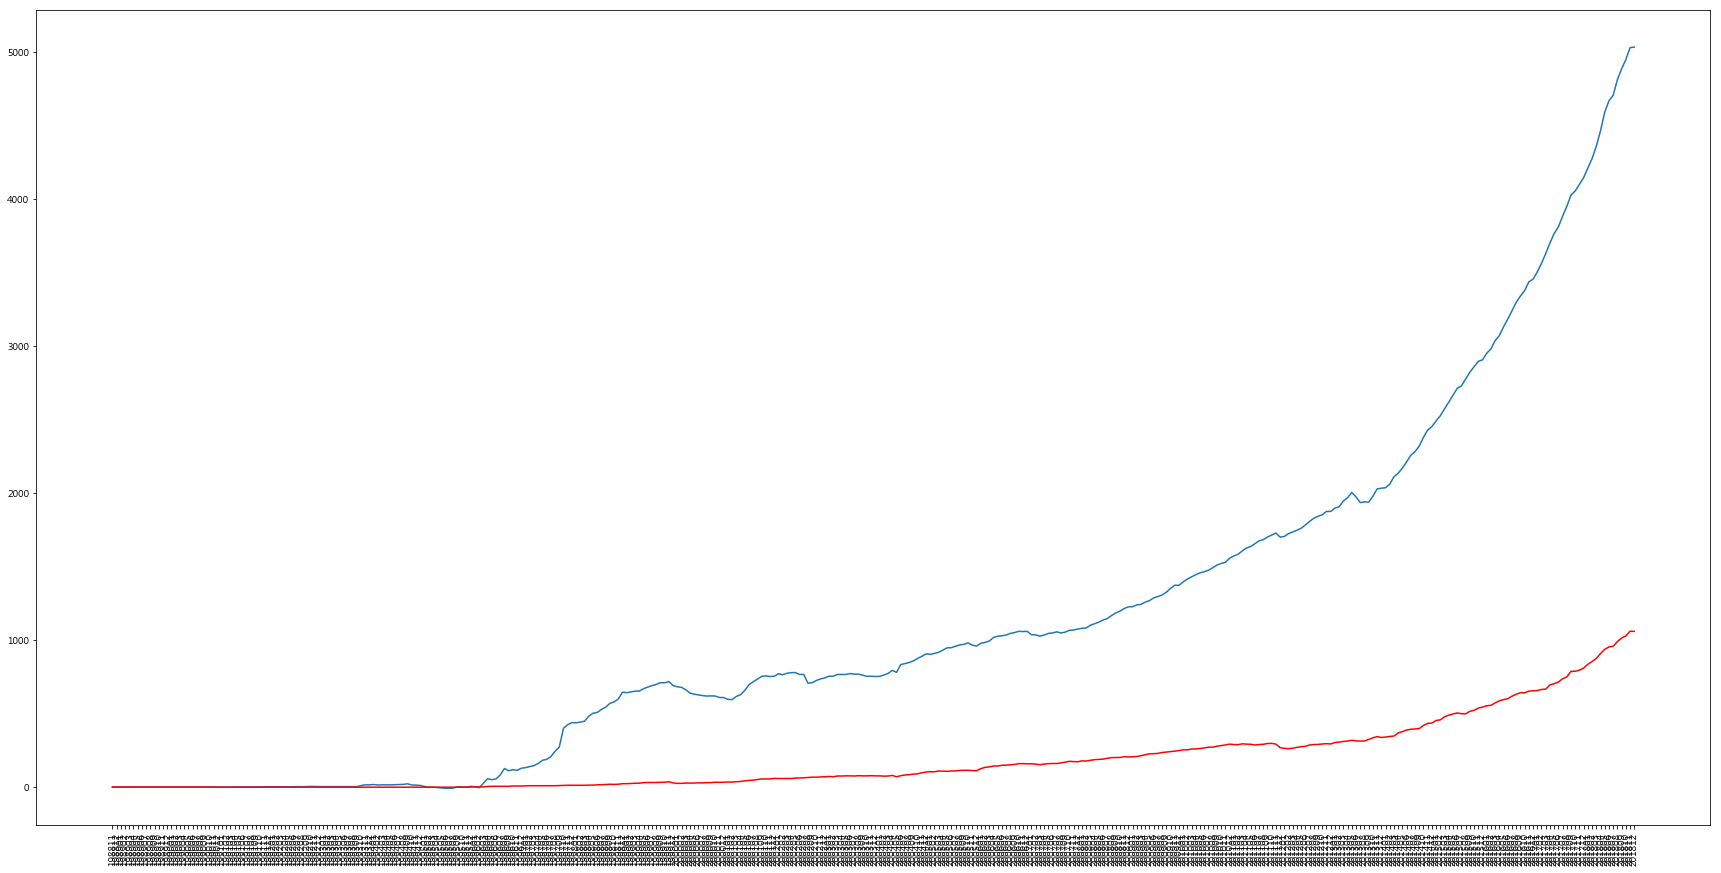

In [194]:
plt.figure(figsize=(30,15))
plt.plot(storeMapo.index, storeMapo.numStore)
plt.plot(franMapo.index, franMapo.numStore, 'r')
plt.xticks(rotation=90)
plt.show()

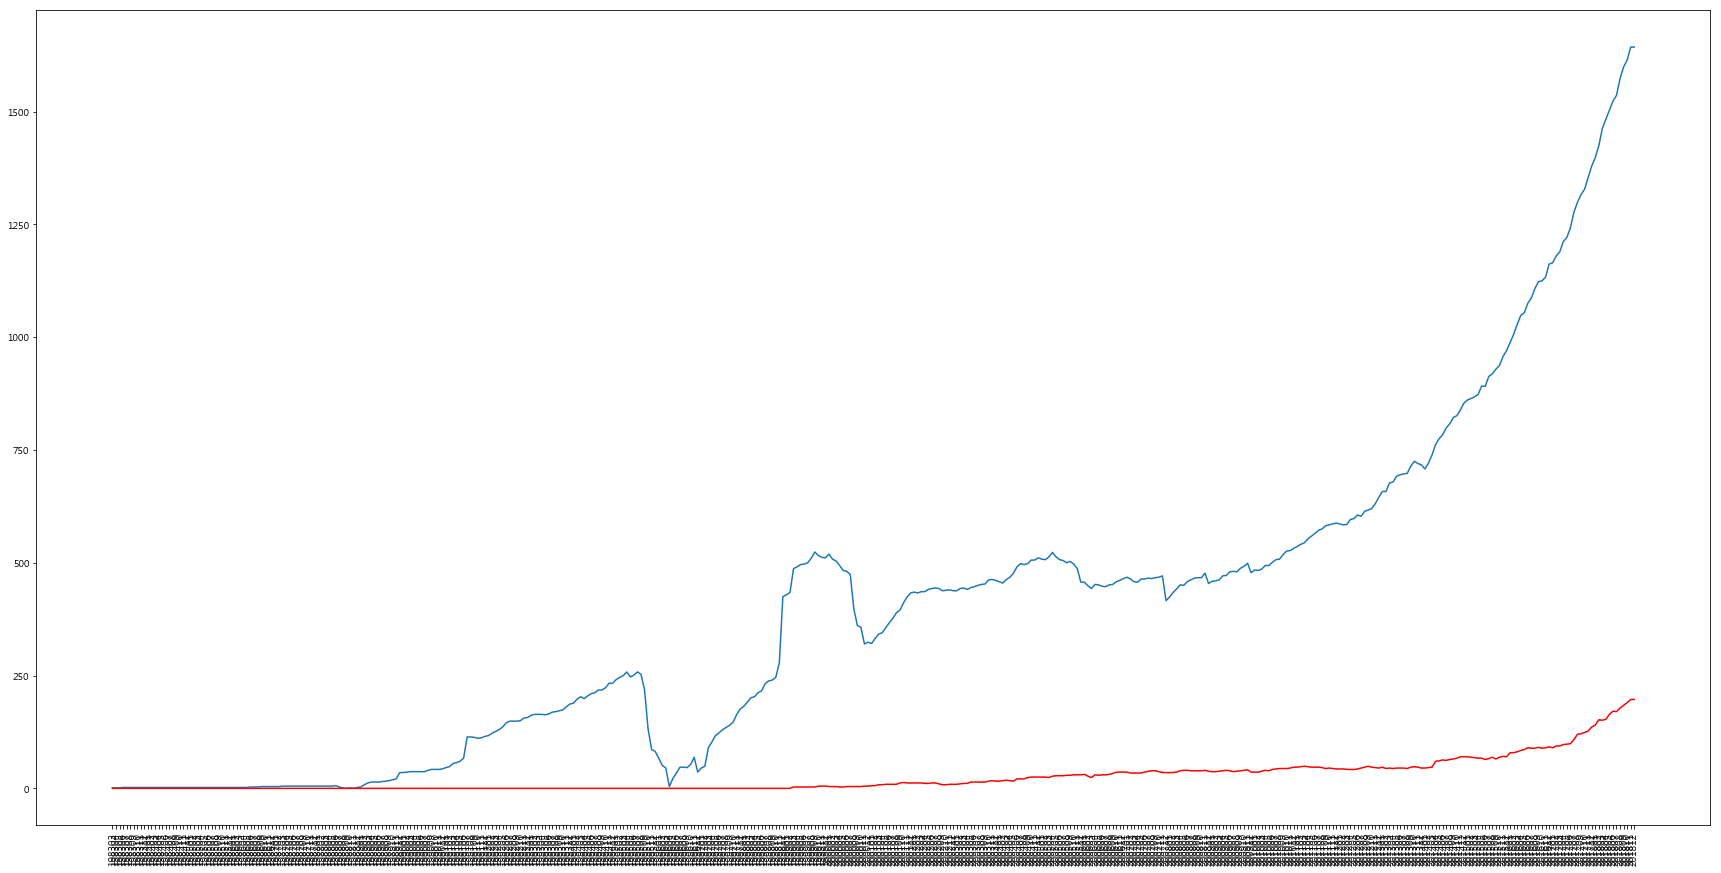

In [201]:
plt.figure(figsize=(30,15))
plt.plot(storeGwangjin.index, abs(storeGwangjin.numStore))
plt.plot(franGwangjin.index, abs(franGwangjin.numStore), 'r')
plt.xticks(rotation=90)
plt.show()

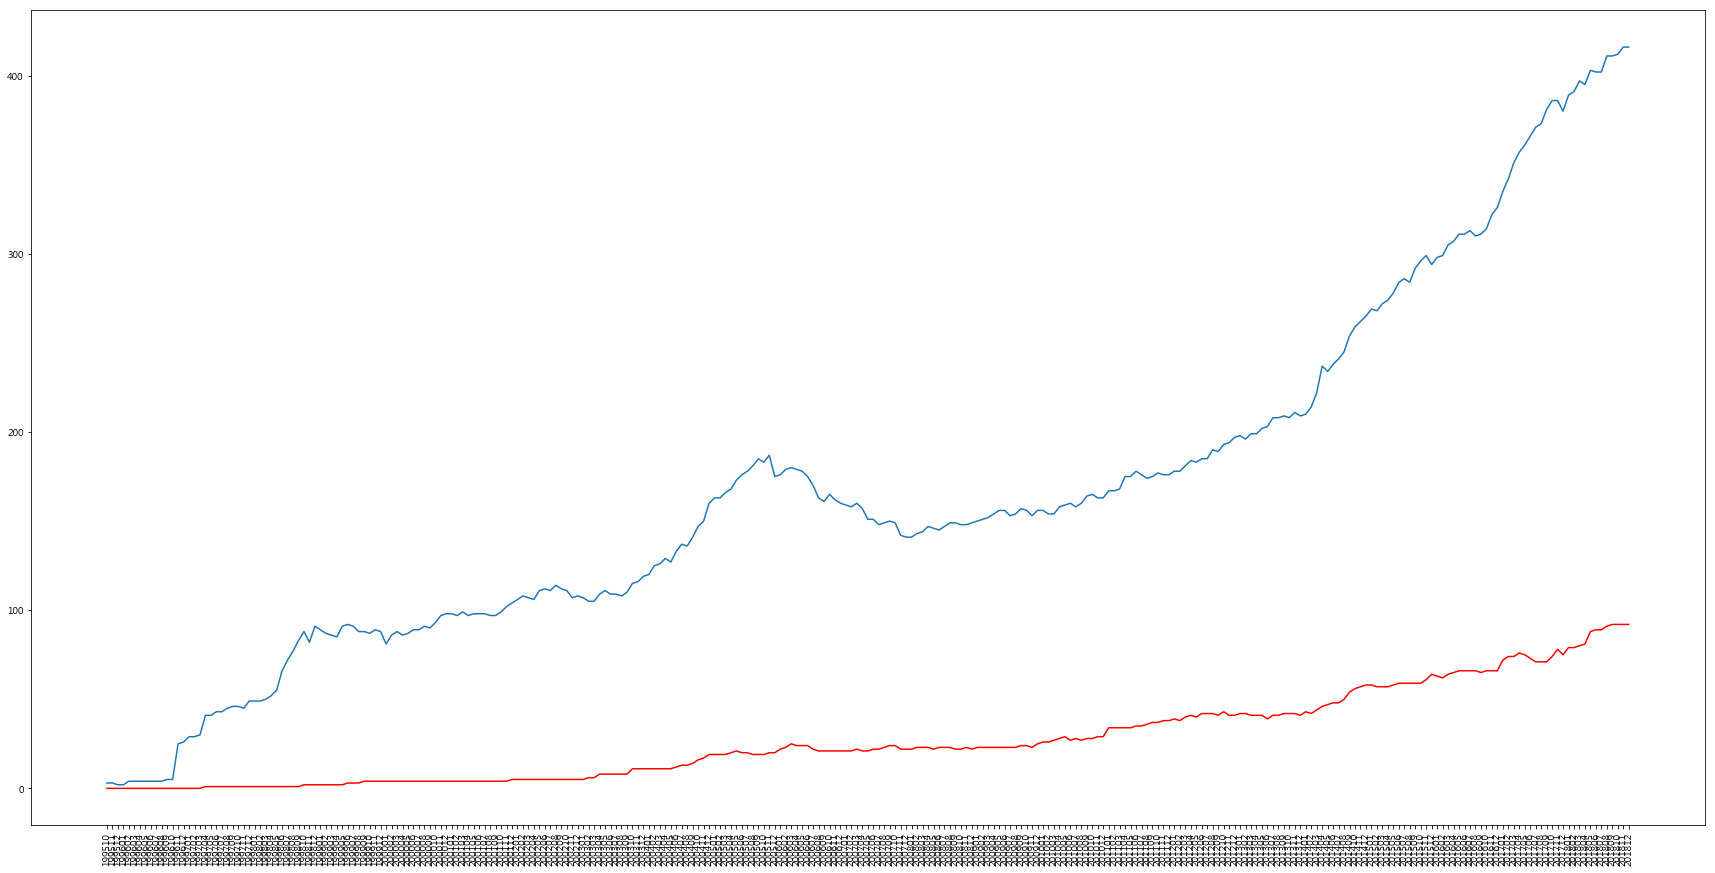

In [200]:
plt.figure(figsize=(30,15))
plt.plot(storeSeongdong.index, storeSeongdong.numStore)
plt.plot(franSeongdong.index, franSeongdong.numStore, 'r')
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.show()

In [198]:
storeGwangjin[storeGwangjin['numStore'] < 0]

,numStore
date,
198812,-2
198901,-3
198902,-8
198903,-12
198904,-14
198905,-14
198906,-14
198907,-15
198908,-16


In [174]:
gwangjin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4667 entries, 0 to 4666
Data columns (total 8 columns):
행정동명      4667 non-null object
업종명       4667 non-null object
업태명       4642 non-null object
업소명       4667 non-null object
법인명       374 non-null object
영업자시작일    4667 non-null object
폐업일자      4667 non-null object
시군구코드     4667 non-null int64
dtypes: int64(1), object(7)
memory usage: 488.1+ KB


In [24]:
gwangjinFood.법인명.unique()

array([nan, '(주)바이더웨이', '주식회사 맛쭈', '한국피자헛 주식회사', '천신상회 주식회사',
       '(주)아이케어와사람들', '(주)클럽간지', '주식회사 다성에프앤씨', '씨제이프레시웨이(주)',
       '(주)씨엠파트너스건축사사무소', '(주)카니발', '(주)프리타임', '드링스코리아 주식회사',
       '비알코리아 주식회사', '(주)두산', '(주)아워홈', '(주)코리아세븐', '(주)영우',
       '(주)스타벅스커피코리아', 'CJ푸드시스템(주)', '(주)스타벅스커피 코리아', '(주)보고아이엔씨',
       '비알코리아(주)', '(주)제퍼빈스코리아', '한림종합건설(주)', '김봉선', '주식회사 바이더웨이',
       '(주)빅이츠코리아', '(주)명가외식산업', '건국대학교', '건국대학교 기숙사 유한회사',
       '주식회사 아이비인베스트먼트', '수원지구축산업협동조합', '(주)탐라엘에스유통', '(주)만수무역',
       '주식회사 다복', '(주)맛드림푸드시스템', '(주)한국보바랜드커피', '(주)휴먼엘씨에스코리아',
       '(주)노른자쇼핑', '(주)니즈팜', '(주)청명섬유', '(주)산정식품', '이기창', '(주)알비케이',
       '이정구', '김광수', '김민수', '(주)덕은대표이사심완조', '카모스', '(주)쏘노트',
       '(주)오가닉 에프앤비', '오자르', '하모니인터내셔날', '천주교', '(주)농협유통화양점', '이두예',
       '상조회장', '설병태', '이병우', '(주)고려인삼파낙시아', '(주)세포활성연구소', '김기태', '엑스페이버',
       '(주)지텍바이오', '(주)카레하우스', '(주)일신앤와이씨', '(주)농협유통', '(주)지에스리테일',
       '(주)동원캐터링', '삼성에버랜드(주)', '씨제이푸드시스템(주)', '세화푸드써비스(주)',
       '주식회사 크라운베이커리', '주식회